In [1]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split

In [31]:
# Fetch the training and test file paths
file_path_full_training_set = '/content/drive/MyDrive/Bhuvan/KDDTrain+.txt'
file_path_test = '/content/drive/MyDrive/Bhuvan/KDDTest+.txt'

In [32]:
# Load the full training set and test set
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)


In [33]:
# Add column names to the datasets
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
           'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
           'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
           'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
           'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
           'attack', 'level']

df.columns = columns
test_df.columns = columns

In [34]:
# Map 'normal' to 0, all attacks to 1 for binary classification
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)


In [35]:
# Add binary attack flag
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack


In [36]:
# Define attack classifications for multi-class classification
dos_attacks = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
U2R = ['buffer_overflow', 'loadmdoule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
Sybil = ['ftp_write', 'guess_passwd', 'http_tunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xclock', 'xsnoop']

In [37]:
# Helper function to classify attacks
def map_attack(attack):
    if attack in dos_attacks:
        return 1  # DoS
    elif attack in probe_attacks:
        return 2  # Probe
    elif attack in U2R:
        return 3  # U2R
    elif attack in Sybil:
        return 4  # Sybil
    else:
        return 0  # Normal

# Apply the attack mapping
df['attack_map'] = df.attack.apply(map_attack)
test_df['attack_map'] = test_df.attack.apply(map_attack)

In [38]:
# Crosstab for attacks vs protocol types
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)

In [39]:
# Helper function for drawing multiple pie charts
def bake_pies(data_list, labels):
    list_length = len(data_list)
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}

    fig, axs = plt.subplots(1, list_length, figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)

    for count, data_set in enumerate(data_list):
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)

        wedges, texts = axs[count].pie(data_set, colors=[cdict[v] for v in data_set.index])
        axs[count].legend(wedges, data_set.index, title="Flags", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        axs[count].set_title(labels[count])

    return axs

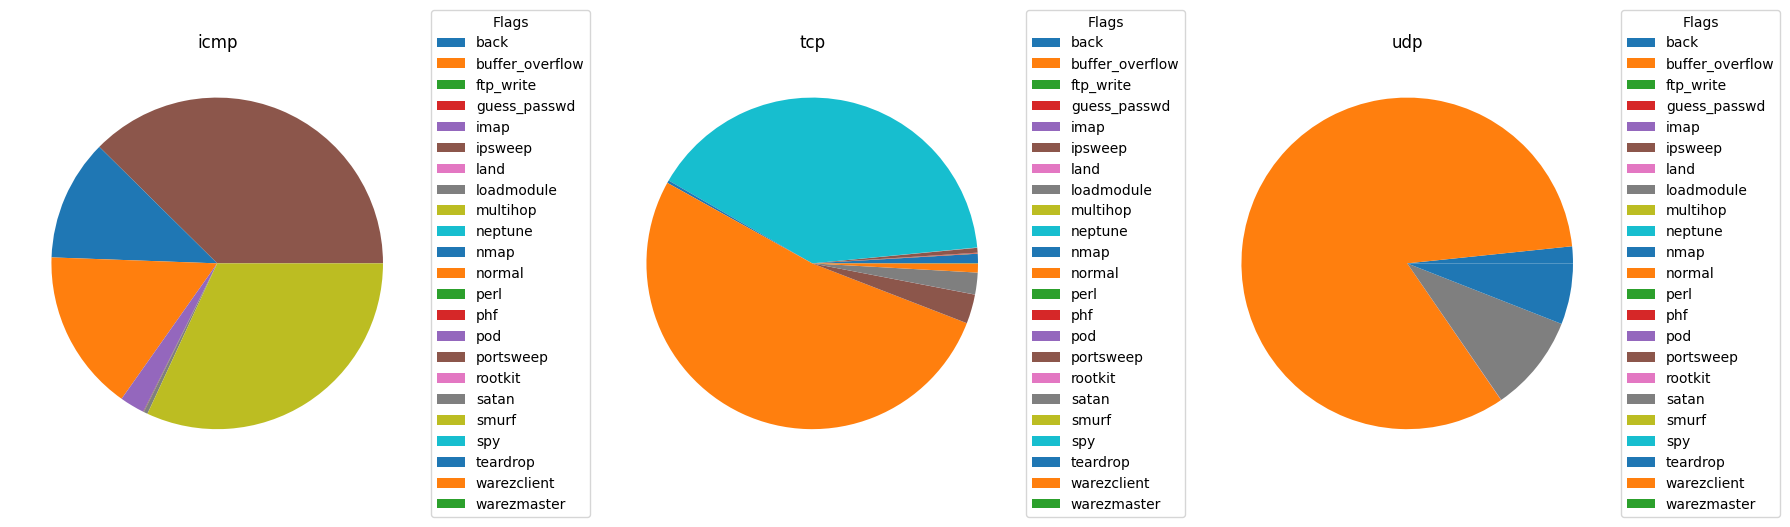

In [40]:
# Generate pie charts for protocol types
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp
bake_pies([icmp_attacks, tcp_attacks, udp_attacks], ['icmp', 'tcp', 'udp'])
plt.show()

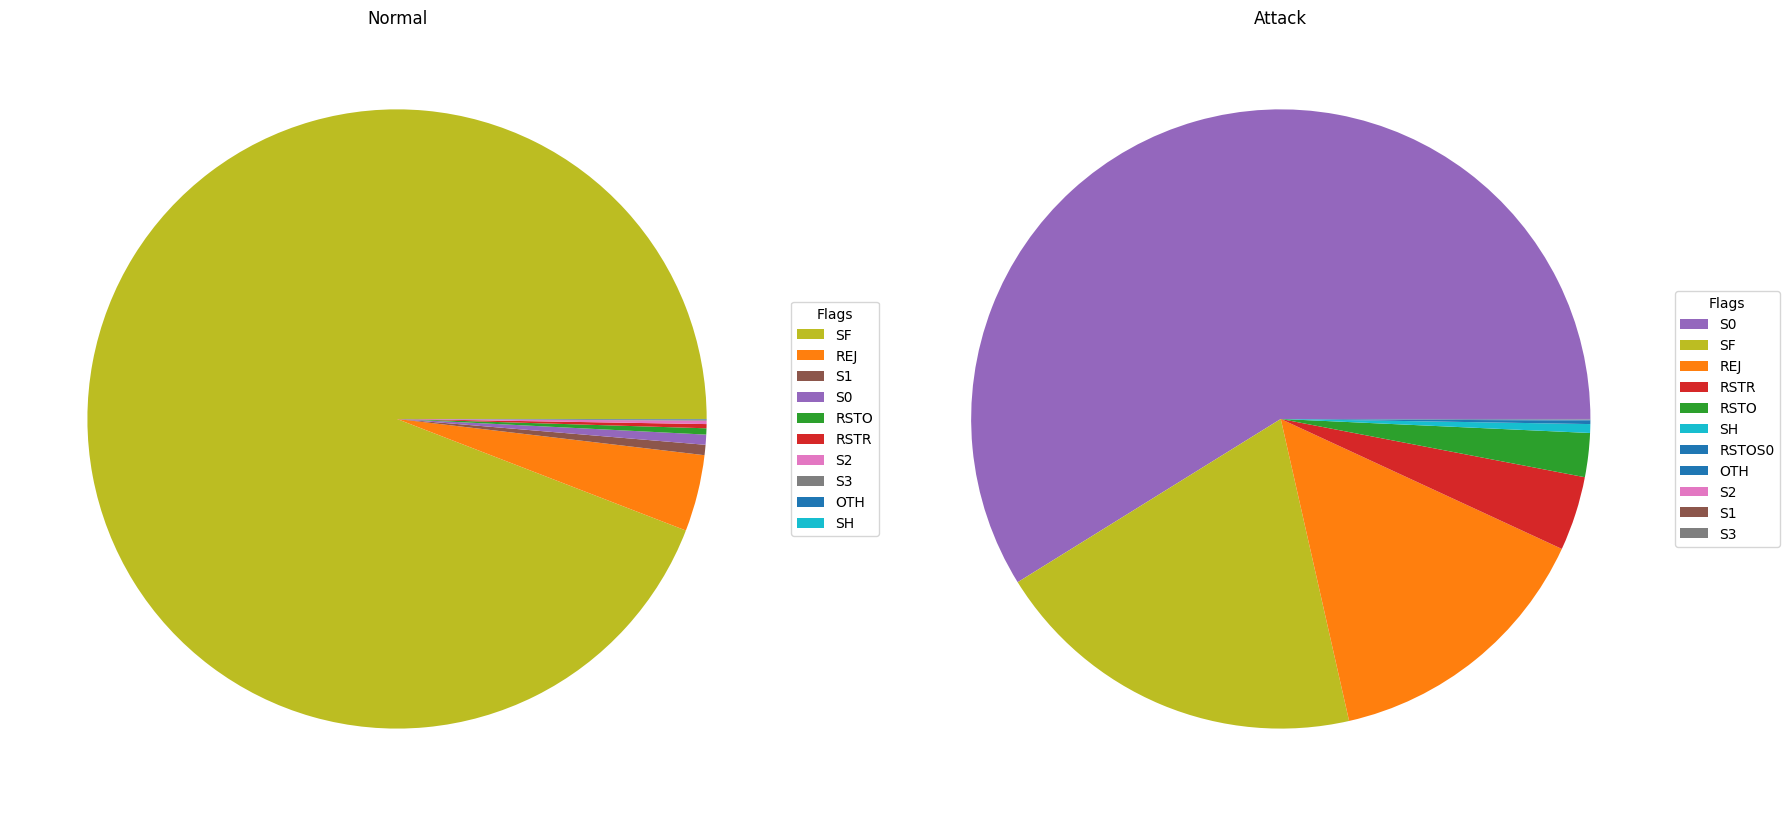

In [41]:
# Flags distribution (normal vs attack)
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()
bake_pies([normal_flags, attack_flags], ['Normal', 'Attack'])
plt.show()

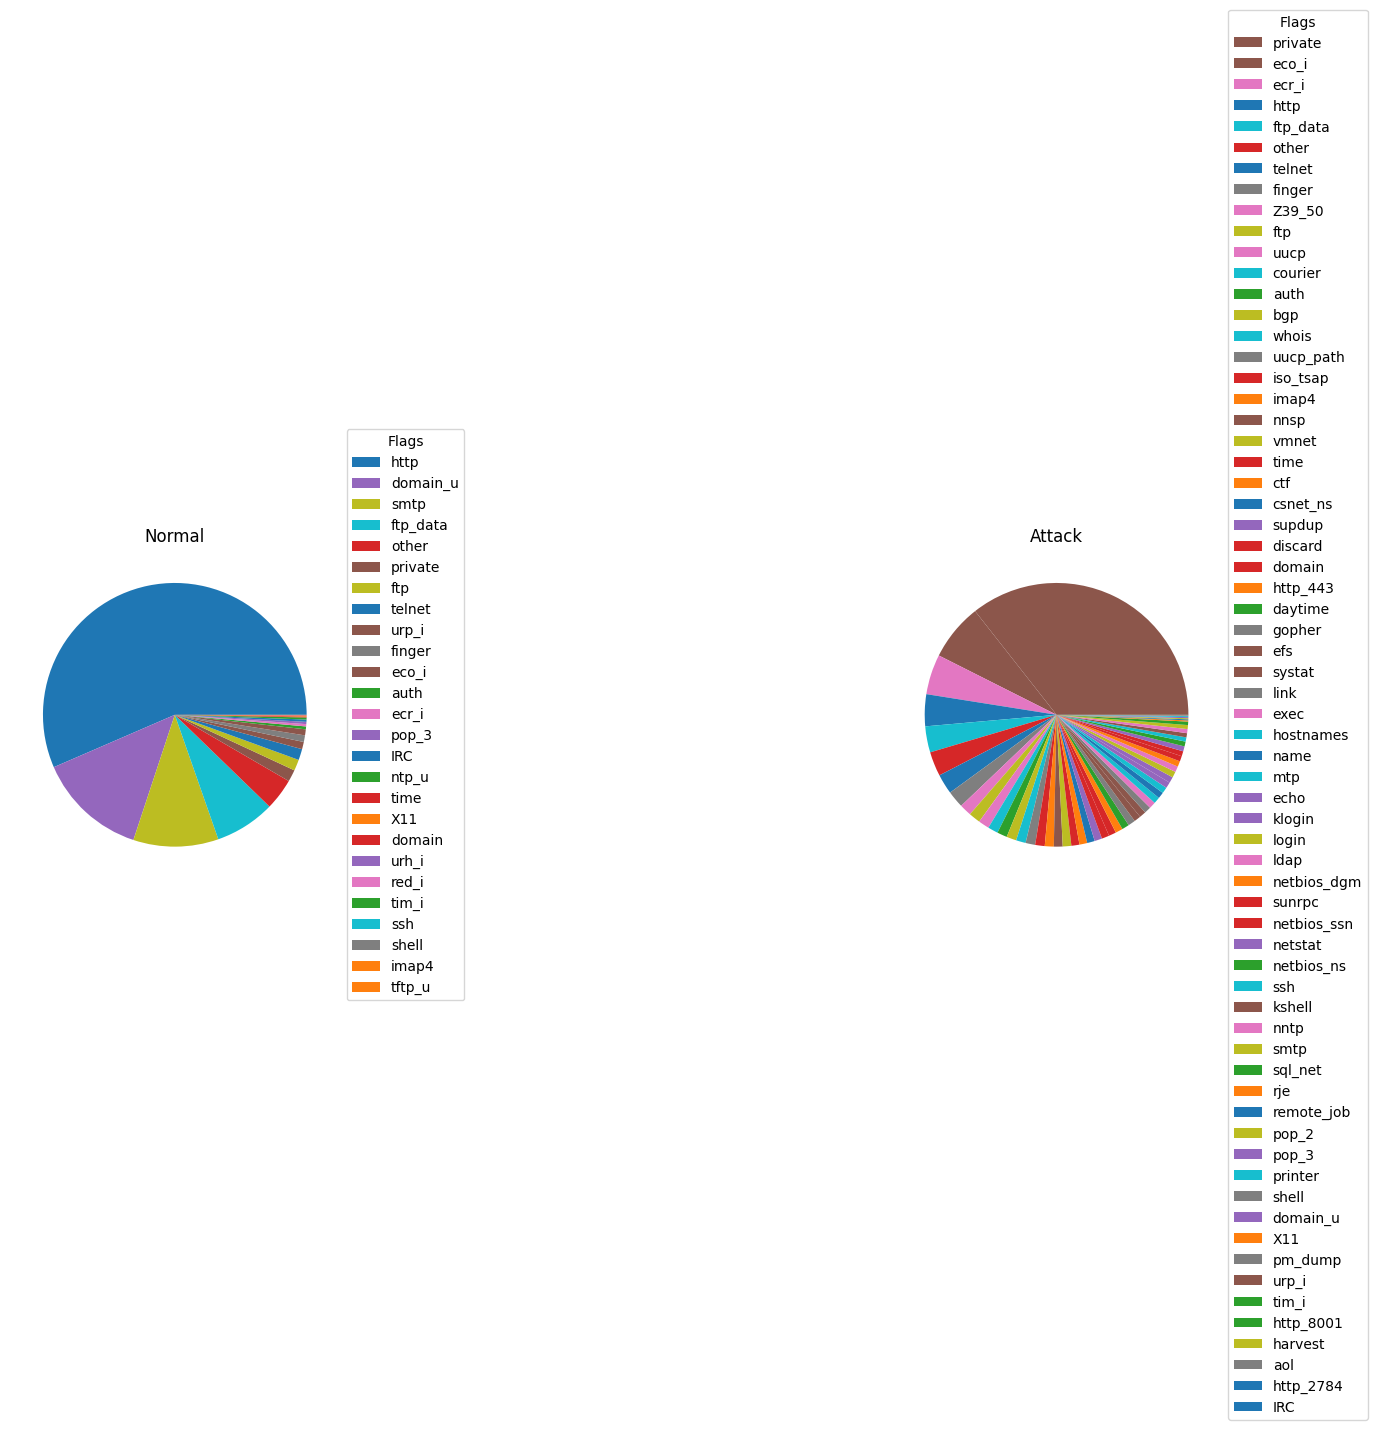

In [42]:
# Services distribution (normal vs attack)
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()
bake_pies([normal_services, attack_services], ['Normal', 'Attack'])
plt.show()

In [43]:
# One-hot encoding of categorical features
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

In [44]:
# Handle missing features in the test set
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values) - set(test_encoded_base.columns.values))
diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

In [45]:
# Append the new columns to the test set
test_encoded_temp = test_encoded_base.join(diff_df)
test_final = test_encoded_temp[encoded.columns.to_list()].fillna(0)

# Add numeric features
numeric_features = ['duration', 'src_bytes', 'dst_bytes']
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [46]:
# Target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

In [47]:
# Train-test split (binary and multi-class classification)
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size=0.6)


In [48]:
# Display the shapes of the datasets to verify correctness
print("Binary Train Set Shape:", binary_train_X.shape)
print("Binary Validation Set Shape:", binary_val_X.shape)
print("Multi-class Train Set Shape:", multi_train_X.shape)
print("Multi-class Validation Set Shape:", multi_val_X.shape)

Binary Train Set Shape: (50388, 87)
Binary Validation Set Shape: (75584, 87)
Multi-class Train Set Shape: (50388, 87)
Multi-class Validation Set Shape: (75584, 87)


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [53]:
# Convert binary classification data into TensorFlow compatible format
binary_train_X_tf = tf.expand_dims(tf.convert_to_tensor(binary_train_X, dtype=tf.float32), -1)
binary_val_X_tf = tf.expand_dims(tf.convert_to_tensor(binary_val_X, dtype=tf.float32), -1)
binary_train_y_tf = tf.convert_to_tensor(binary_train_y, dtype=tf.float32)
binary_val_y_tf = tf.convert_to_tensor(binary_val_y, dtype=tf.float32)

# Convert multi-class classification data into TensorFlow compatible format
multi_train_X_tf = tf.expand_dims(tf.convert_to_tensor(multi_train_X, dtype=tf.float32), -1)
multi_val_X_tf = tf.expand_dims(tf.convert_to_tensor(multi_val_X, dtype=tf.float32), -1)
multi_train_y_tf = tf.convert_to_tensor(multi_train_y, dtype=tf.int32)
multi_val_y_tf = tf.convert_to_tensor(multi_val_y, dtype=tf.int32)

In [54]:
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(binary_train_X.shape[1], 1)),  # Add proper input shape (number of features, 1)
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [55]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
# Train the model
history_cnn = cnn_model.fit(binary_train_X_tf, binary_train_y_tf, epochs=10, validation_data=(binary_val_X_tf, binary_val_y_tf), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8722 - loss: 53.8756 - val_accuracy: 0.9485 - val_loss: 9.0457
Epoch 2/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9369 - loss: 0.4462 - val_accuracy: 0.9398 - val_loss: 0.1958
Epoch 3/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9356 - loss: 0.2001 - val_accuracy: 0.9439 - val_loss: 0.1650
Epoch 4/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9380 - loss: 0.1885 - val_accuracy: 0.9438 - val_loss: 0.1569
Epoch 5/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9394 - loss: 0.1792 - val_accuracy: 0.9438 - val_loss: 0.1415
Epoch 6/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9387 - loss: 0.1684 - val_accuracy: 0.9438 - val_loss: 0.1318
Epoch 7/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9399 - loss: 0.1799 - val_accuracy: 0.9439 - val_loss: 0.1317
Epoch 8/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9392 - loss: 0.1532 

In [60]:
# For RNN/LSTM, no need to add an extra dimension for channels
binary_train_X_tf = tf.convert_to_tensor(binary_train_X, dtype=tf.float32)  # Shape (batch_size, timesteps)
binary_val_X_tf = tf.convert_to_tensor(binary_val_X, dtype=tf.float32)      # Shape (batch_size, timesteps)
binary_train_y_tf = tf.convert_to_tensor(binary_train_y, dtype=tf.float32)
binary_val_y_tf = tf.convert_to_tensor(binary_val_y, dtype=tf.float32)
# Same for multi-class classification data
multi_train_X_tf = tf.convert_to_tensor(multi_train_X, dtype=tf.float32)
multi_val_X_tf = tf.convert_to_tensor(multi_val_X, dtype=tf.float32)
multi_train_y_tf = tf.convert_to_tensor(multi_train_y, dtype=tf.int32)
multi_val_y_tf = tf.convert_to_tensor(multi_val_y, dtype=tf.int32)

In [61]:
# RNN model for binary classification
rnn_model = Sequential([
    Embedding(input_dim=binary_train_X.shape[1], output_dim=128),  # input_dim is the number of features/columns
    tf.keras.layers.SimpleRNN(128, activation='relu', return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [62]:
# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
# Train the model
history_rnn = rnn_model.fit(binary_train_X_tf, binary_train_y_tf, epochs=10, validation_data=(binary_val_X_tf, binary_val_y_tf))

Epoch 1/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9494 - loss: 0.1596 - val_accuracy: 0.9615 - val_loss: 0.1485
Epoch 2/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9628 - loss: 0.1291 - val_accuracy: 0.9735 - val_loss: 0.1039
Epoch 3/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9675 - loss: 0.1175 - val_accuracy: 0.9343 - val_loss: 0.2083
Epoch 4/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9490 - loss: 0.1502 - val_accuracy: 0.9727 - val_loss: 0.0984
Epoch 5/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9660 - loss: 0.1140 - val_accuracy: 0.9765 - val_loss: 0.0920
Epoch 6/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9605 - loss: 0.1260 - val_accuracy: 0.9735 - val_loss: 0.1032
Epoch 7/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9606 - loss: 0.1312 - val_accuracy: 0.9318 - val_loss: 0.1684
Epoch 8/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9477 -

In [65]:
# LSTM model for binary classification
lstm_model = Sequential([
    Embedding(input_dim=binary_train_X.shape[1], output_dim=128),
    LSTM(128, activation='relu', return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [66]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
# Train the model
history_lstm = lstm_model.fit(binary_train_X_tf, binary_train_y_tf, epochs=10, validation_data=(binary_val_X_tf, binary_val_y_tf), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.8929 - loss: 84.4088 - val_accuracy: 0.9312 - val_loss: 0.1955
Epoch 2/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9054 - loss: 3498094.2500 - val_accuracy: 0.9315 - val_loss: 0.2047
Epoch 3/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9277 - loss: 0.2128 - val_accuracy: 0.9259 - val_loss: 0.1498
Epoch 4/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9380 - loss: 0.1590 - val_accuracy: 0.9312 - val_loss: 0.1383
Epoch 5/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9504 - loss: 0.1427 - val_accuracy: 0.9748 - val_loss: 0.1273
Epoch 6/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9591 - loss: 0.1459 - val_accuracy: 0.9753 - val_loss: 0.1153
Epoch 7/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9691 - loss: 0.1216 - val_accuracy: 0.9759 - val_loss: 0.0984
Epoch 8/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0

In [68]:
# Evaluate the models
def evaluate_model(model, X_val, y_val):
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)

    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')

In [69]:
# Evaluate CNN Model
print("CNN Model Evaluation:")
evaluate_model(cnn_model, binary_val_X_tf, binary_val_y_tf)

CNN Model Evaluation:
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy: 0.9441151566469094
Precision: 0.9892598793315854
Recall: 0.8896622255049572
F1 Score: 0.9368213228035538
AUC: 0.9406214205552671


In [70]:
# Evaluate RNN Model
print("RNN Model Evaluation:")
evaluate_model(rnn_model, binary_val_X_tf, binary_val_y_tf)

RNN Model Evaluation:
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Accuracy: 0.9550301651143099
Precision: 0.9404221138931974
Recall: 0.9645464617482458
F1 Score: 0.9523315335530468
AUC: 0.9556407370029394


In [71]:
# Evaluate LSTM Model
print("LSTM Model Evaluation:")
evaluate_model(lstm_model, binary_val_X_tf, binary_val_y_tf)

LSTM Model Evaluation:
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
Accuracy: 0.9756694538526672
Precision: 0.9874634716540035
Recall: 0.959944319763643
F1 Score: 0.9735094567926131
AUC: 0.9746605188447515


In [73]:
# Plot training and validation accuracy/loss for a model
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


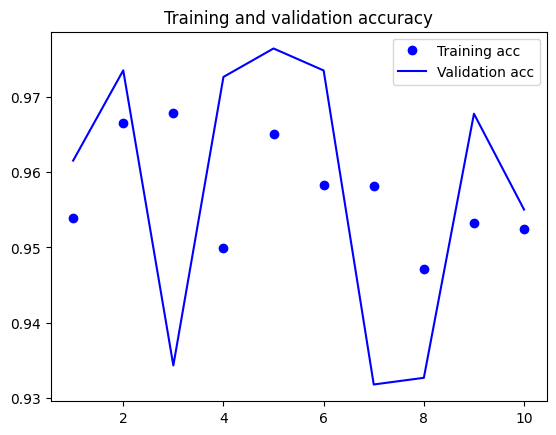

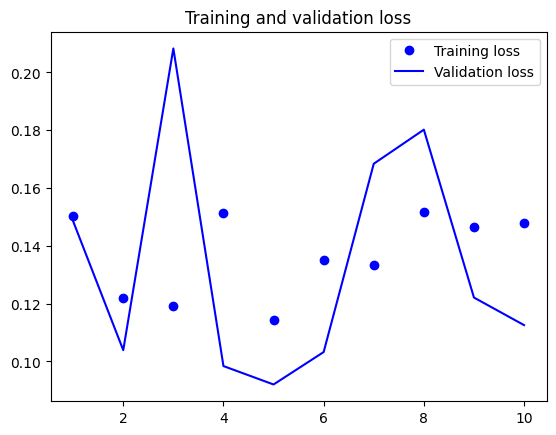

In [74]:
plot_history(history_rnn)

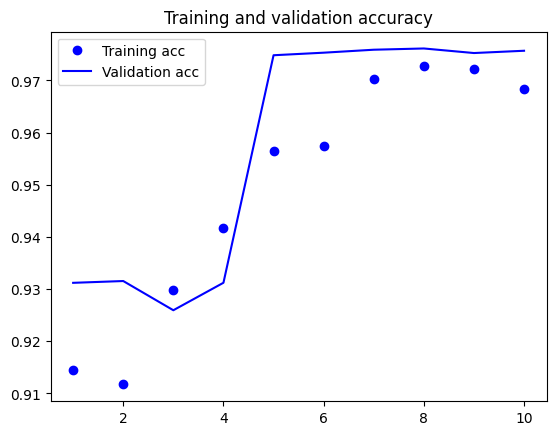

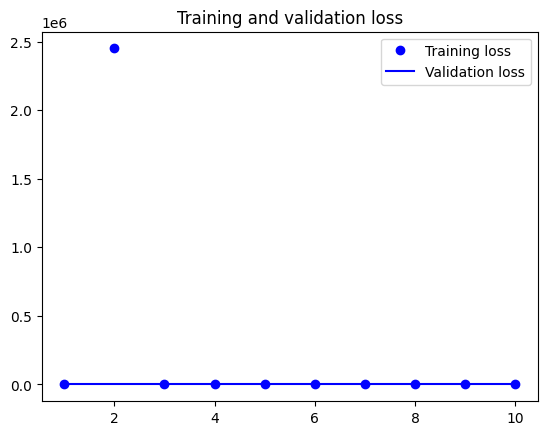

In [75]:
plot_history(history_lstm)

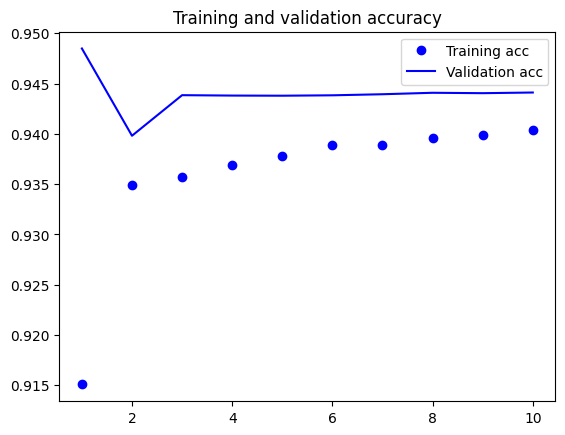

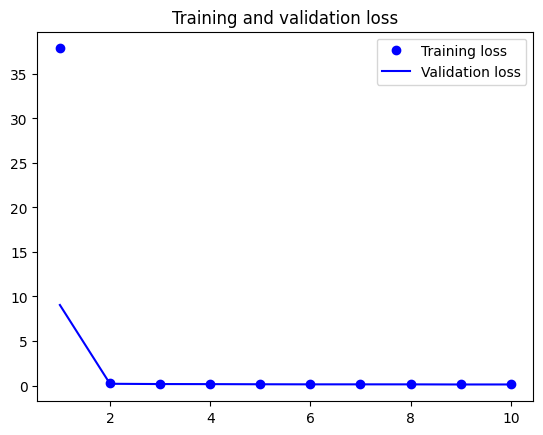

In [76]:
plot_history(history_cnn)

In [81]:
# Save the model
lstm_model.save('best_lstm_model.keras')

In [82]:
# Corrected Hybrid CNN + LSTM model for binary classification
hybrid_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(binary_train_X.shape[1], 1)),  # input_shape should be (timesteps, channels)
    MaxPooling1D(pool_size=2),
    LSTM(128, activation='relu', return_sequences=False),  # LSTM layer after CNN
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

In [83]:
# Compile the hybrid model
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [85]:
# Train the hybrid model
history_hybrid = hybrid_model.fit(binary_train_X_tf, binary_train_y_tf, epochs=10, validation_data=(binary_val_X_tf, binary_val_y_tf))

Epoch 1/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7819 - loss: 2.0107 - val_accuracy: 0.8871 - val_loss: 0.4163
Epoch 2/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8948 - loss: 0.3187 - val_accuracy: 0.9209 - val_loss: 0.2388
Epoch 3/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9118 - loss: 0.2782 - val_accuracy: 0.9442 - val_loss: 0.1935
Epoch 4/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9252 - loss: 0.2117 - val_accuracy: 0.9641 - val_loss: 0.1255
Epoch 5/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9543 - loss: 0.1447 - val_accuracy: 0.9629 - val_loss: 0.1118
Epoch 6/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9595 - loss: 0.1369 - val_accuracy: 0.9683 - val_loss: 0.1223
Epoch 7/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9583 - loss: 0.1435 - val_accuracy: 0.9707 - val_loss: 0.1143
Epoch 8/10
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9605 -

In [86]:
# Function to evaluate the model with standard metrics
def evaluate_model(model, X_val, y_val):
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)

    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')

# Evaluate the Hybrid CNN + LSTM Model
print("Hybrid CNN + LSTM Model Evaluation:")
evaluate_model(hybrid_model, binary_val_X_tf, binary_val_y_tf)

Hybrid CNN + LSTM Model Evaluation:
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Accuracy: 0.974955016934801
Precision: 0.9894780155184576
Recall: 0.9563932842816966
F1 Score: 0.9726543878656555
AUC: 0.9737640838861372


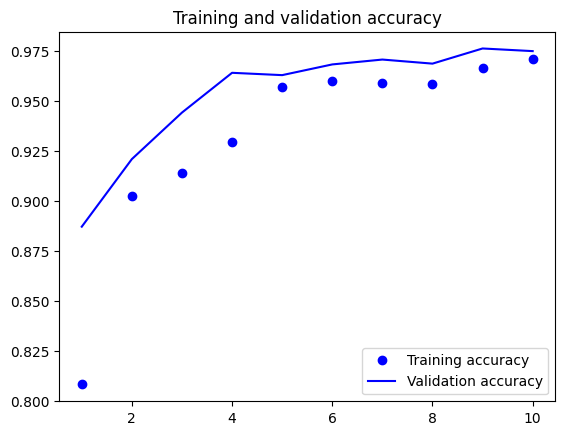

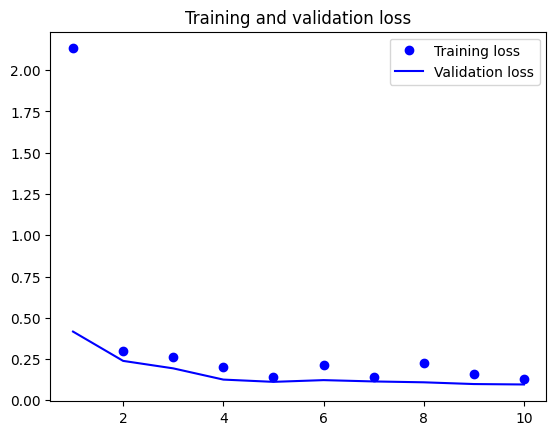

In [87]:
import matplotlib.pyplot as plt

# Function to plot the history of the model training
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    # Plot training and validation loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Plot the training history for the hybrid model
plot_history(history_hybrid)